# Solutions

## Setup

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

fb = pd.read_csv('../../ch_06/data/fb_stock_prices_2018.csv', index_col='date', parse_dates=True)
quakes = pd.read_csv('../../ch_06/data/earthquakes.csv')

## Exercise 1
Using `seaborn`, create a heatmap to visualize the correlation coefficients between earthquake magnitude and whether or not there is a tsunami with the 'mb' `magType`.

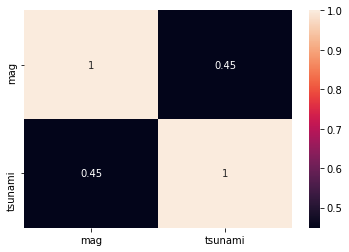

In [2]:
sns.heatmap(
    quakes.query('magType == "mb"')[['mag','tsunami']].corr(), 
    annot=True
)

## Exercise 2
Create a box plot of Facebook volume traded and closing price and draw reference lines for the bounds of a Tukey fence with a multiplier of 1.5. 

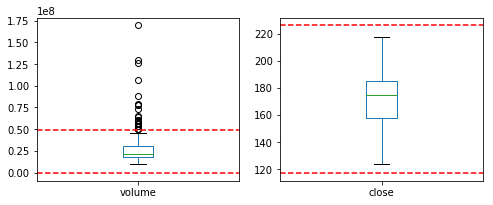

In [3]:
cols = ['volume', 'close']
subset = fb[cols]

quantiles = subset.quantile([0.25, 0.75])
quantiles.loc['iqr',:] = quantiles.loc[0.75,:] - quantiles.loc[0.25,:]

axes = subset.plot(kind='box', subplots=True, figsize=(8, 3))
for ax, col in zip(axes, cols):
    stats = quantiles[col]
    lower = stats.loc[0.25] - 1.5 * stats['iqr']
    upper = stats.loc[0.75] + 1.5 * stats['iqr']
    for bound in [lower, upper]:
        ax.axhline(
            bound, 
            color='red', 
            linestyle='dashed'
        )

## Exercise 3
Fill in the area inside the bounds in the plot from exercise 2.

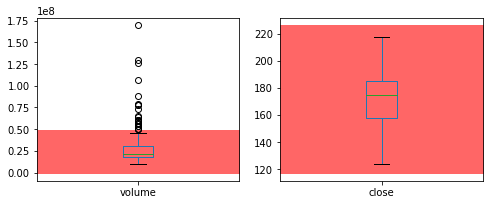

In [4]:
cols = ['volume', 'close']
subset = fb[cols]

quantiles = subset.quantile([0.25, 0.75])
quantiles.loc['iqr',:] = quantiles.loc[0.75,:] - quantiles.loc[0.25,:]

axes = subset.plot(kind='box', subplots=True, figsize=(8, 3))
for ax, col in zip(axes, cols):
    stats = quantiles[col]
    lower = stats.loc[0.25] - 1.5 * stats['iqr']
    upper = stats.loc[0.75] + 1.5 * stats['iqr']
    ax.fill_between(
        [0,2],
        lower,
        upper, 
        color='#ff6666'
    )

## Exercise 4
Use `axvspan()` to shade a rectangle from '2018-07-25' to '2018-07-31' marking the large decline in Facebook price on a line graph of closing price.

Text(0.5, 0.98, 'Facebook Closing Price')

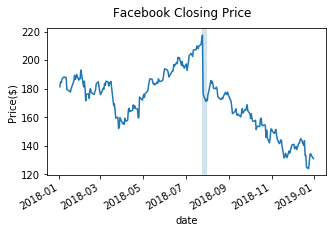

In [5]:
fb.close.plot(kind='line', figsize=(5, 3))
plt.axvspan('2018-07-25', '2018-07-31', alpha=0.2)
plt.ylabel('Price($)')
plt.suptitle('Facebook Closing Price')

## Exercise 5
Using the Facebook stock data, annotate the following three events on a line graph of closing price:
1. 'Disappointing user growth announced after close' on July 25, 2018
2. 'Cambridge Analytica story breaks' on March 19, 2018 (when it affected the market)
3. 'FTC launches investigation' on March 20, 2018

Text(0.5, 0.98, 'Facebook Closing Price')

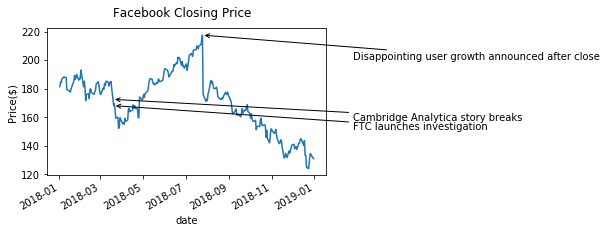

In [6]:
fb.close.plot(kind='line', figsize=(5, 3))
notes = [
    ('Disappointing user growth announced after close', '2018-07-25'),
    ('Cambridge Analytica story breaks', '2018-03-19'),
    ('FTC launches investigation', '2018-03-20')
]
for text, date in notes:
    y_value = fb.close[date]
    jitter = np.random.uniform(-20, -10, 1)
    plt.annotate(
        text, 
        xy=(date, y_value),
        xytext=('2019-02-25', y_value + jitter),
        arrowprops=dict(arrowstyle='->')
    )
plt.ylabel('Price($)')
plt.suptitle('Facebook Closing Price')

## Exercise 6
Modify the `reg_resid_plot()` function to use a matplotlib colormap instead of cycling between two colors. Remember, for this use case, you should pick a qualitative colormap or make your own.

In [7]:
import itertools

import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

def reg_resid_plots(data):
    """
    Using seaborn, plot the regression and residuals
    plots side-by-side for every permutation of 2 columns 
    in the data.

    Parameters:
        - data: A pandas DataFrame
    Returns:
        A matplotlib Figure object.
    """
    num_cols = data.shape[1]
    permutation_count = num_cols * (num_cols - 1)

    fig, ax = plt.subplots(
        permutation_count, 
        2, 
        figsize=(15, 4 * permutation_count)
    )

    for (x, y), axes, color in zip(
        itertools.permutations(data.columns, 2), 
        ax,
        [cm.Dark2(i) for i in range(len(ax))]
    ):
        for subplot, func in zip(axes, (sns.regplot, sns.residplot)):
            func(
                x=x, 
                y=y,
                data=data,
                ax=subplot,
                color=color
            )
    plt.close()
    return fig

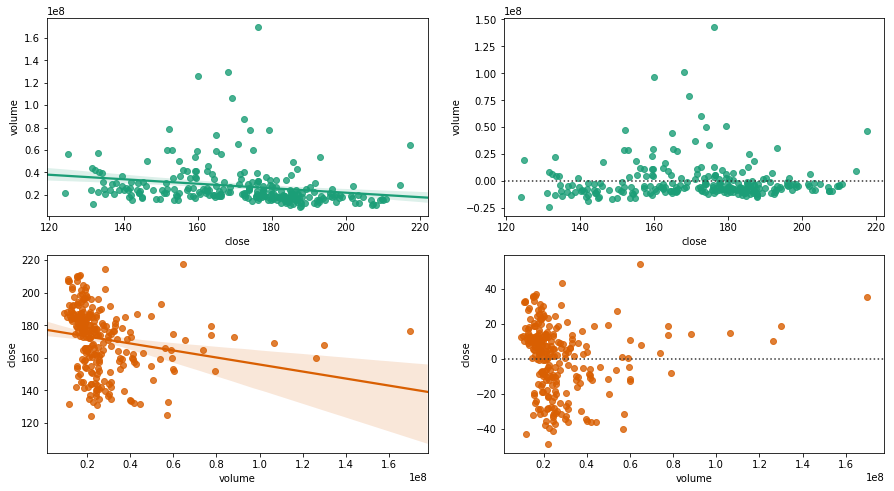

In [8]:
reg_resid_plots(fb[['close', 'volume']])